# Movie Database MVP

The purpose of this Project is to ...
* Help the user find good movies to watch
* Provide user with quick recommendations, summaries, and other info about the movies
* Provide the user with a Machine Learning output of what the movie should be rated


### **What four (+) methods have you chosen and how do they fit together?**

1.   Data Wrangling and NLP Pipeline
2.   Text Similarity
3.   Text Summarization
4.   Document Clustering (Part 1 for the class / Part 2 was for fun)

**Description of how these methods will be meaningfully combined**:

I will create a python interface that has most of my finished functions in it. Since most functions simply require a movie title, I will have a search bar
and all the functions will run with that movie title. It will then print out the information from all the functions in a nice page. I have also created a second page for document clustering part 2 (my fun addition) as a bonus feature. Overall, each of these methods will come together to create a functing movie recommender system that also re-evaluates the certificate ratings of movies, provides text summarizations, and text simmilarities for movie titles. 



##### Dependences
...Nothing to see here.

In [2]:
# Loading Dependances
import pandas as pd
import regex as re
import altair as alt
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import textwrap

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import sklearn

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package punkt to C:\Users\Wyatt
[nltk_data]     Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Wyatt
[nltk_data]     Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Wyatt
[nltk_data]     Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Download the Dataset & Wrangle

In this section I ...
* Downloaded the dataframe from a github file that I loaded up to github for convinence.
* Updated Country to only the primary country that produced the movie.
* Cleaned up the Maturity Columns
  * Some movies like "Snow White" do not have any profanity in them. They do however have some mild violence. Since the movie
  does not have profanity, it labels that column as No Rating, when in fact it should be none. 
  * Movies that were not rated on any level were not updated. They remained as Not Rated.
* Stanardized the Name column to make searching for movies easier
* Created a Summary Column by taking the synopsis (long-text) as the primary option and if there was no synopsis then the plot would fill in to avoid NAs.

In [3]:
movies = pd.read_excel('https://raw.githubusercontent.com/Williams-W/movie_ml/main/finished_movie_merge.xlsx')

# Update the Country Column to the Primary Country
movies['Country'] = movies['Country'].apply(lambda x: re.sub(r'[^\w\s,]', '', str(x))) # Clean up the Column
movies['Country'] = movies['Country'].str.split(',').str[0] # Take only the first one

# Clean up the Maturity Ratings (Some movies have "No Rate" when they should have "None" instead)

attributes = ['Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']

def update_attribute(row, attribute):
    if row[attribute] == "No Rate":
        if any(row[attr] != "No Rate" for attr in attributes if attr != attribute):
            return "None"
    return row[attribute]

# Apply the update_attribute function to each row for each attribute
for attribute in attributes:
    movies[attribute] = movies.apply(lambda row: update_attribute(row, attribute), axis=1)

# Clean up the Name column to be standardized
movies['Name'] = movies['Name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())

# Create a Summary Column & Remove Non-Needed Columns
#regex_pattern = re.compile(r'https(?=\S*[\s]|$)\S*|[^a-zA-Z\s.?!,]', re.A)
movies['Summary'] = movies['Synopsis'].fillna(movies['Plot'])#.apply(lambda x: re.sub(regex_pattern, lambda y: ' ' if y.group() in ('.', '!', '?', ',') else y.group(), x))
movies = movies.drop(['Synopsis', 'Plot', 'Genres'], axis=1)
movies

,Name,Date,Rate,Genre,Duration,Certificate,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificates,Summary
0,nosferatu,1922,7.9,"Fantasy, Horror",94,Not Rated,None,Mild,None,Mild,Moderate,Germany,"Argentina:13,Australia:PG,Brazil:12,Canada:PG:...",The story is narrated from the diary of Johann...
1,metropolis,1927,8.3,"Drama, Sci-Fi",153,Not Rated,Mild,Mild,None,Mild,Moderate,Germany,"['Argentina:Atp', 'Australia:G', 'Brazil:Livre...",['(This is the synopsis of the full 150 minute...
2,snow white and the seven dwarfs,1937,7.6,"Animation, Family, Fantasy",83,G,None,Mild,None,None,Mild,United States,"['Argentina:Atp', 'Australia:G', 'Brazil:Livre...","['A beautiful but orphaned princess, Snow Whit..."
3,stage door,1937,7.8,"Comedy, Drama",92,PG,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:Atp', 'Canada:PG::(Ontario)', 'Can...","['A chronicle of the ambitions, dreams, and di..."
4,the wizard of oz,1939,8.0,"Adventure, Family, Fantasy",102,G,None,Mild,None,None,Mild,United States,"['Argentina:Atp', 'Australia:G', 'Brazil:Livre...",['Dorothy Gale (Judy Garland) is an orphaned t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,guardians of the galaxy vol 3,2023,No Rate,"Action, Adventure, Comedy",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:13::(with warning)', 'Australia:M'...","['As a baby raccoon, Rocket is a test subject ..."
2944,oppenheimer,2023,No Rate,"Biography, Drama, History",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:13', 'Australia:MA15+', 'Austria:1...","[""Part 1: Accusations and Confrontations\nThe ..."
2945,shazam fury of the gods,2023,No Rate,"Action, Adventure, Comedy",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:13', 'Australia:M', 'Brazil:12', '...","['Two years after Thaddeus Sivana\'s defeat, H..."
2946,the little mermaid,2023,No Rate,"Adventure, Family, Fantasy",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:Atp::(with warning)', 'Australia:P...",['Ariel is a mermaid princess and the youngest...


##### Finished Wrangling Output

In [4]:
# Look for Movies
movies.query('Name == "nosferatu"')

,Name,Date,Rate,Genre,Duration,Certificate,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificates,Summary
0,nosferatu,1922,7.9,"Fantasy, Horror",94,Not Rated,None,Mild,None,Mild,Moderate,Germany,"Argentina:13,Australia:PG,Brazil:12,Canada:PG:...",The story is narrated from the diary of Johann...


##### NLP - Pipeline

In this step I ...

* Created a Regex Pattern
* Casefolded and stripped the text
* Tokenized on word level
* Removed stopwords
* Lemmatized the text
* Created a normalized corpus in a list
* Joined the texts and stored them in a new column called Summary_Cleaned
* The normalized corpus will be used in Text Similarity and Document Clustering
 

In [5]:
import re
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

regex_pattern = re.compile(r'https(?=\S*[\s]|$)\S*|[^a-zA-Z\s]', re.A)
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    tag = tag[0].upper()
    tag_dict = {"N": "n", "V": "v", "R": "r", "J": "a"}
    return tag_dict.get(tag, "n")

def normalize_document(plot):
    plot = regex_pattern.sub('', plot)
    plot = plot.lower()
    plot = plot.strip()
    tokens = nltk.word_tokenize(plot)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Add POS tags to the tokens
    tagged_tokens = pos_tag(tokens)

    # Lemmatize with POS tags
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag))
              for token, pos_tag in tagged_tokens]

    plot = ' '.join(lemmas)
    return plot

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(movies['Summary']))  # Norm Corpus used in Text Similarity Section
movies['Summary_cleaned'] = norm_corpus
movies

[nltk_data] Downloading package punkt to C:\Users\Wyatt
[nltk_data]     Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Wyatt
[nltk_data]     Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Wyatt Williams\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Name,Date,Rate,Genre,Duration,Certificate,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificates,Summary,Summary_cleaned
0,nosferatu,1922,7.9,"Fantasy, Horror",94,Not Rated,None,Mild,None,Mild,Moderate,Germany,"Argentina:13,Australia:PG,Brazil:12,Canada:PG:...",The story is narrated from the diary of Johann...,story narrate diary johann cavallius historian...
1,metropolis,1927,8.3,"Drama, Sci-Fi",153,Not Rated,Mild,Mild,None,Mild,Moderate,Germany,"['Argentina:Atp', 'Australia:G', 'Brazil:Livre...",['(This is the synopsis of the full 150 minute...,synopsis full minute versionprologuethe film s...
2,snow white and the seven dwarfs,1937,7.6,"Animation, Family, Fantasy",83,G,None,Mild,None,None,Mild,United States,"['Argentina:Atp', 'Australia:G', 'Brazil:Livre...","['A beautiful but orphaned princess, Snow Whit...",beautiful orphan princess snow white live step...
3,stage door,1937,7.8,"Comedy, Drama",92,PG,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:Atp', 'Canada:PG::(Ontario)', 'Can...","['A chronicle of the ambitions, dreams, and di...",chronicle ambition dream disappointment aspire...
4,the wizard of oz,1939,8.0,"Adventure, Family, Fantasy",102,G,None,Mild,None,None,Mild,United States,"['Argentina:Atp', 'Australia:G', 'Brazil:Livre...",['Dorothy Gale (Judy Garland) is an orphaned t...,dorothy gale judy garland orphan teenager life...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,guardians of the galaxy vol 3,2023,No Rate,"Action, Adventure, Comedy",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:13::(with warning)', 'Australia:M'...","['As a baby raccoon, Rocket is a test subject ...",baby raccoon rocket test subject high evolutio...
2944,oppenheimer,2023,No Rate,"Biography, Drama, History",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:13', 'Australia:MA15+', 'Austria:1...","[""Part 1: Accusations and Confrontations\nThe ...",part accusation confrontationsnthe story comme...
2945,shazam fury of the gods,2023,No Rate,"Action, Adventure, Comedy",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:13', 'Australia:M', 'Brazil:12', '...","['Two years after Thaddeus Sivana\'s defeat, H...",two year thaddeus sivanas defeat hespera helen...
2946,the little mermaid,2023,No Rate,"Adventure, Family, Fantasy",None,None,No Rate,No Rate,No Rate,No Rate,No Rate,United States,"['Argentina:Atp::(with warning)', 'Australia:P...",['Ariel is a mermaid princess and the youngest...,ariel mermaid princess young daughter king tri...


##### Text Simmilarity

* One-Hot Encoded Genres
* Created a Cosine-Similarity on Genre
* Created a tfidf matrix and did Cosine-Similarity on the summary of each movie
* Created a function that...
  * Takes a movie title, a list of the names of movies, the genre cosine matrix, and summary cosine matrix
  * The function takes the movie title, converts it to an index number and runs a similarity on both the genre and summary matrices.
  * Adds the similarity scores together and returns the index numbers which becomes a list of movies 
* A way to simply run the function and get similarities

In [6]:
# One hot encoded Genre
genres = movies['Genre'].str.split(',', expand=True).apply(lambda x: x.str.strip())
movies_summarization = pd.concat([movies, pd.get_dummies(genres, prefix='Genre').max(level=0, axis=1)], axis=1)
movies_summarization = movies_summarization.drop(['Genre'], axis=1)

movies_summarization

C:\Users\WYATTW~1\AppData\Local\Temp/ipykernel_696/3554458031.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  movies_summarization = pd.concat([movies, pd.get_dummies(genres, prefix='Genre').max(level=0, axis=1)], axis=1)


,Name,Date,Rate,Duration,Certificate,Nudity,Violence,Profanity,Alcohol,Frightening,...,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Short,Genre_Thriller,Genre_Western,Genre_Film-Noir,Genre_Music,Genre_Sport,Genre_War
0,nosferatu,1922,7.9,94,Not Rated,None,Mild,None,Mild,Moderate,...,0,0,0,0,0,0,0,0,0,0
1,metropolis,1927,8.3,153,Not Rated,Mild,Mild,None,Mild,Moderate,...,0,0,1,0,0,0,0,0,0,0
2,snow white and the seven dwarfs,1937,7.6,83,G,None,Mild,None,None,Mild,...,0,0,0,0,0,0,0,0,0,0
3,stage door,1937,7.8,92,PG,No Rate,No Rate,No Rate,No Rate,No Rate,...,0,0,0,0,0,0,0,0,0,0
4,the wizard of oz,1939,8.0,102,G,None,Mild,None,None,Mild,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,guardians of the galaxy vol 3,2023,No Rate,None,None,No Rate,No Rate,No Rate,No Rate,No Rate,...,0,0,0,0,0,0,0,0,0,0
2944,oppenheimer,2023,No Rate,None,None,No Rate,No Rate,No Rate,No Rate,No Rate,...,0,0,0,0,0,0,0,0,0,0
2945,shazam fury of the gods,2023,No Rate,None,None,No Rate,No Rate,No Rate,No Rate,No Rate,...,0,0,0,0,0,0,0,0,0,0
2946,the little mermaid,2023,No Rate,None,None,No Rate,No Rate,No Rate,No Rate,No Rate,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# For Genre Information
genre_df = pd.DataFrame(movies_summarization.iloc[:, movies_summarization.columns.get_loc("Genre_Action"):movies_summarization.columns.get_loc("Genre_War")])
genre_matrix = cosine_similarity(genre_df)
cosine_sim_genre = pd.DataFrame(genre_matrix, index=genre_df.index, columns=genre_df.index)

In [8]:
# For Summary Information
tf = TfidfVectorizer(ngram_range = (1,2), min_df=3, max_df=0.8)  
tfidf_matrix = tf.fit_transform(norm_corpus)
summary_matrix = cosine_similarity(tfidf_matrix)                     
cosine_sim_summary = pd.DataFrame(summary_matrix)          

In [9]:
# Text Similarity
movie_list = movies['Name'].values

def movie_recommender(movie_title, movie=movie_list, summary =cosine_sim_summary, genre = cosine_sim_genre):

    movie_idx = np.where(movie == movie_title.lower())[0][0] #locate the index number of the user provided title
    
    movie_similarities = summary.iloc[movie_idx].values # create a list of similarity scores for that movie.
    genre_similarities = genre.iloc[movie_idx].values

    combined_sim = movie_similarities + genre_similarities # Add the similarity scores
    
    similar_movie_idxs = np.argsort(-combined_sim)[1:7] # Get the top movies index based on similarity score
    
    similar_movies = movie_list[list(similar_movie_idxs)] # match those index numbers to the movie title

    return print("Based on your interest in", movie_title.title().strip(), "you might enjoy:", ", ".join(movie.title() for movie in similar_movies))   

In [10]:
movie_recommender('howls moving castle')

Based on your interest in Howls Moving Castle you might enjoy: The Bfg, Spirited Away, Walle, Treasure Planet, James And The Giant Peach, Wolfwalkers


##### Try Out My Text Simmilarity 

In [11]:
movie_recommender('howls moving castle')

Based on your interest in Howls Moving Castle you might enjoy: The Bfg, Spirited Away, Walle, Treasure Planet, James And The Giant Peach, Wolfwalkers


##### Bonus Simmilarity Feature

I created a query option that takes your query and looks for similar text within the synopsis of the movie

In [12]:
def query_movie_recommender(search_query, movies=movie_list, tfidf_matrix=tfidf_matrix):
    # Transform the search query into its vector form
    query_vector = tf.transform([search_query])

    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix)

    similar_movie_idxs = cosine_similarities[0].argsort()[-5:][::-1]

    similar_movies = movies[similar_movie_idxs]

    return print("Based on your search query, I'd recommend checking out:", ", ".join(movie.title() for movie in similar_movies))

##### Try my Query Feature Here

In [13]:
query_movie_recommender('christmas')

Based on your search query, I'd recommend checking out: How The Grinch Stole Christmas, The Nightmare Before Christmas, National Lampoons Christmas Vacation, The Expendables, The Polar Express


##### Text Summarization
Broken into 2 Sections:

Section 1:

* Created a new Regex Pattern
* Performed similar NLP clean-up
* Tokenized By Sentences
* Cleaned up each sentence by removing stop words and lemmatizing each sentence
* Stored the cleaned sentences into a list for each row
* Stored those lists in a new column called Normalized_Summary

Section 2: 

* Using the Normalized_Summary I performed cosine similarity to find which sentences where most similar
* I then sorted the sentences and selected the top 10 sentences
* I had to clean up the original sentences a bit to take care of strange characters and puncuation issues.
* I then matched the top 10 sentences of the choppy normalized text with the original text to make coherent sentences
* Once the sentences were replaced, I reordered them in their original chronolgical order instead of most similar order 
* I stored the new summaries into a column called Summarized_Text


In [14]:
# Document Summarization
regex_pattern = re.compile(r'https(?=\S*[\s]|$)\S*|[^a-zA-Z\s.?!]', re.A) # My new Regex rules to include ending punctuation to catch end of sentences

def normalize_document(plot):
    plot = regex_pattern.sub('', plot) # apply the regex pattern
    plot = plot.lower() # Clean up
    plot = plot.strip()
    plot = re.sub(r'\.', ' . ', plot) # replace any periods with a space on both sides so that it will be properly tokenized.

    sentences = nltk.sent_tokenize(plot) # tokenize the sentences
    
    normalized_sentences = [] # empty list to put strings into
    
    for sentence in sentences:
        words = word_tokenize(sentence) # Now that we have tokenized by sentences we need to clean up at the word level within each sentence
        stop_words = set(stopwords.words('english')) # Remove stopwords from each sentence
        words = [word for word in words if word not in stop_words]
        lemmas = [lemmatizer.lemmatize(word) for word in words] # Lemmatize Each sentence
        processed_sentence = ' '.join(lemmas) #join all of my remaining words (words that were not removed by stop words) and join them back together at the sentence level
        if processed_sentence == '.': 
            continue
        else: normalized_sentences.append(processed_sentence) # Add the cleaned sentences together into a list.
    
    return normalized_sentences # Return the normalized list with all the sentences
# Apply the function and make a new column based on the lists. Each cell has a list in it with each section being a cleaned sentence. 
movies['Normalized_Summary'] = movies['Summary'].apply(normalize_document)

In [15]:
for index, row in movies.iterrows(): # We are going to go through every row in our data set to make a similarity matrix
    sentences = row["Normalized_Summary"]
    vectorizer = TfidfVectorizer() # Vectorize and make a Matrix
    sentence_vectors =vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(sentence_vectors, sentence_vectors)
    similarity_df = pd.DataFrame(similarity_matrix, index=range(len(sentences)), columns=range(len(sentences)))
    
    # Here we score the similarity of each sentence in a total column and make an index column. We then sort by the score
    similarity_df["Total"] = similarity_df.sum(axis=1)
    similarity_df['index_column'] = range(0, len(similarity_df))
    similarity_df = similarity_df.sort_values(by='Total', ascending=False)

    # Now that the Matrix is made and sorted, we need to clean our original sentences
    regex_pattern = re.compile(r'https(?=\S*[\s]|$)\S*|[^a-zA-Z\s.?!,0-9]', re.A) # including commas and numbers for original sentences
    plot = row["Summary"] # We will apply the same basic cleaning as before so that the sentences align
    plot = regex_pattern.sub('', plot)
    plot = plot.strip()
    plot = re.sub(r'\.', '. ', plot)

    # Because some sentences were not useful, we replaced any sentences with less than 5 words with nothing
    def replace_short_sentences(sentences, min_words=5, replacement=''): 
        return [sentence if len(sentence.split()) >= min_words else replacement for sentence in sentences]

    # Apply the Cleaning Process and Shortening Function
    original_sentences = sent_tokenize(plot)
    original_sentences = replace_short_sentences(original_sentences)

    # We will select the top 10 scores from our matrix and replace the normalized (stopwords/lemmatized) text with the original text that we just made
    top_5_indices = similarity_df[['Total','index_column']].head(10)
    top_5_indices = top_5_indices.sort_values(by='index_column', ascending=True)
    top_5_indices = top_5_indices['index_column'].tolist()
    top_5_sentences = [original_sentences[i] for i in top_5_indices if i < len(original_sentences)]

    # We will assign these sentences into a string that will be stored in a new column called "summarized_text"
    movies.at[index, 'Summarized_Text'] = ' '.join(top_5_sentences)

In [16]:
# Function to take a movie title and find the index number and print the "Summarized Text" for that index number

def summarize_a_movie(movie_title):
    movie_title = movie_title.lower() 
    movie_num = movies.index[movies['Name'].str.lower() == movie_title].tolist()
    
    if not movie_num:
        print(f"Movie with title '{movie_title}' not found.")
        return
    
    movie_num = movie_num[0]  # Extract the first (and presumably only) element
    
    text_cleaned = movies['Summarized_Text'][movie_num].replace('\\', '')
    text_cleaned = textwrap.fill(text_cleaned, width=150)
    
    print("Here is the plot of", movie_title.title(), ": \n")
    print(text_cleaned)

##### Try Out My Text Summarization

In [17]:
summarize_a_movie("princess mononoke")

Here is the plot of Princess Mononoke : 

San tells him to go away before disappearing into the forest with the wolves. One of Sans brothers attacks Ashitaka but San calls him off before
confronting Ashitaka about stopping her from killing Eboshi. After the boars leave, San and Ashitaka see the Forest Spirit walking on the water of the
lake. An AmbushIn the forest, a hunter reports to Jigo and Lady Eboshi that Lord Okkoto is badly wounded and heading for the domain of the Forest
Spirit San is with him. Ashitaka leaps onto Okkotos snout and tries to dig San out while the wolf brothers fight off the hunters, but Ashitaka is
thrown off by the demon before he can get to San. Ashitaka takes San from Moro and returns to the water to wash the demon tendrils from her. San rips
the crystal necklace from around her neck and orders Ashitaka to let her kill Eboshi, but he assures San that Moros revenge has been taken and tells
Eboshi he promised the women hed return her to them. Ashitaka, San, and

##### Document Clustering Part 1

* Trimmed the movies dataframe to just the columns I need in a new dataframe called movies_cluster
* Removed all movies that were not made in the United States, don't have a Certificate (G, PG, etc.), and do not have any information in any of the maturity columns
* I also updated the maturity from "None", "Moderate", etc to ordinal numeric values (0:4) to be used much later
* Made a Chart to show the distribution of remaining movie certificates
* Used a TfidfVectorizer to vectorize the Summary Cleaned Column
* Used a Random Forest on vectorized text and got rankings for each of the maturity categories based on the text
* The accuracy was really good on "Frightening", "Violence" and "Nudity"
* The accuracy was terrible on "Profanity" and medicore on "Alcohol".
* I then applied the model on the foreign movies and created a foreign_movies dataframe to append the predicted output to

In [18]:
movies_cluster = movies[['Name','Date','Nudity','Violence','Profanity','Alcohol','Frightening','Country','Certificate', 'Summary_cleaned']]
movies_cluster = movies_cluster.query('Country == "United States"')
movies_cluster = movies_cluster.query("Certificate != 'Not Rated' & Certificate != 'None'")
movies_cluster = movies_cluster[~movies_cluster[['Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']].eq('No Rate').all(axis=1)]

ordinal_mapping = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}
movies_cluster.replace(ordinal_mapping, inplace=True)
movies_cluster.head(1)

,Name,Date,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificate,Summary_cleaned
2,snow white and the seven dwarfs,1937,0,1,0,0,1,United States,G,beautiful orphan princess snow white live step...


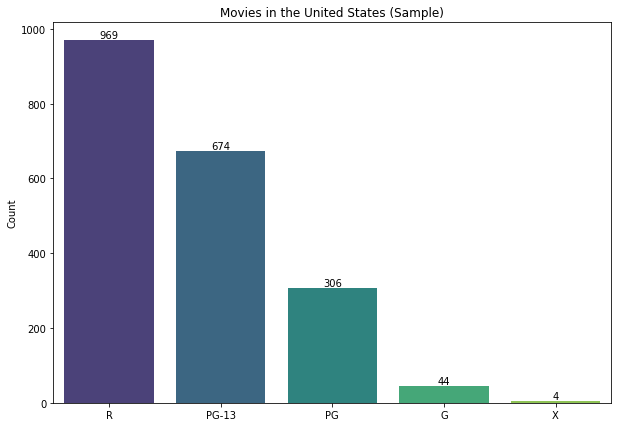

In [19]:
counts = movies_cluster['Certificate'].value_counts()

# Plotting
plt.figure(figsize=(10, 7))
sns.countplot(x='Certificate', data=movies_cluster, order=counts.index, palette='viridis')

# Adding count labels on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('Count')
plt.title('Movies in the United States (Sample)')
plt.show()

In [20]:
norm_corpus = normalize_corpus(list(movies_cluster['Summary_cleaned']))

# Create a TfidfVectorizer
tv = TfidfVectorizer(ngram_range=(1, 2), min_df=20, max_df=0.75)

# Apply the vectorizer to the normalized corpus
tv_matrix = tv.fit_transform(norm_corpus)

# Convert the sparse matrix to a dense array
tv_matrix = tv_matrix.toarray()

# Get the vocabulary (feature names)
vocab = tv.get_feature_names_out()

# Create a DataFrame to display the TF-IDF matrix
tfidf_df =pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)


In [21]:
from sklearn.multioutput import MultiOutputClassifier
# Apply vectorizer to normalized corpus
X = tfidf_df

# Extract labels (maturity ratings)
y = movies_cluster[['Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier for each label using MultiOutputClassifier
classifier = MultiOutputClassifier(RandomForestClassifier(), n_jobs=-1)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

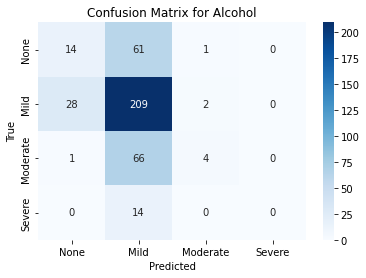


Classification Report for Alcohol:
              precision    recall  f1-score   support

           0       0.33      0.18      0.24        76
           1       0.60      0.87      0.71       239
           2       0.57      0.06      0.10        71
           3       1.00      0.00      0.00        14

    accuracy                           0.57       400
   macro avg       0.62      0.28      0.26       400
weighted avg       0.56      0.57      0.49       400



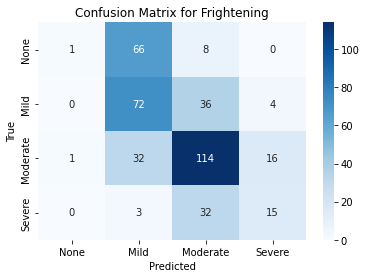


Classification Report for Frightening:
              precision    recall  f1-score   support

           0       0.50      0.01      0.03        75
           1       0.42      0.64      0.51       112
           2       0.60      0.70      0.65       163
           3       0.43      0.30      0.35        50

    accuracy                           0.51       400
   macro avg       0.49      0.41      0.38       400
weighted avg       0.51      0.51      0.45       400



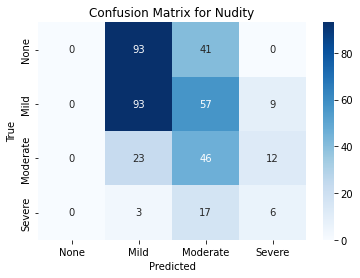


Classification Report for Nudity:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       134
           1       0.44      0.58      0.50       159
           2       0.29      0.57      0.38        81
           3       0.22      0.23      0.23        26

    accuracy                           0.36       400
   macro avg       0.49      0.35      0.28       400
weighted avg       0.58      0.36      0.29       400



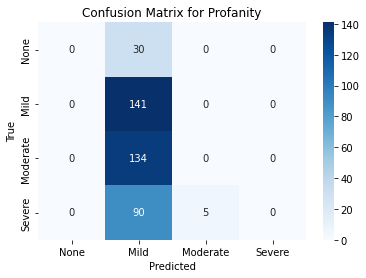


Classification Report for Profanity:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        30
           1       0.36      1.00      0.53       141
           2       0.00      0.00      1.00       134
           3       1.00      0.00      0.00        95

    accuracy                           0.35       400
   macro avg       0.59      0.25      0.38       400
weighted avg       0.44      0.35      0.52       400



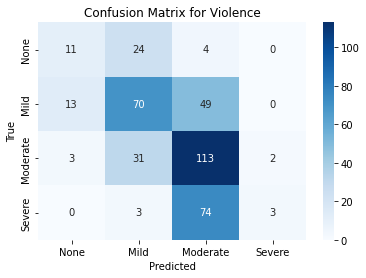


Classification Report for Violence:
              precision    recall  f1-score   support

           0       0.41      0.28      0.33        39
           1       0.55      0.53      0.54       132
           2       0.47      0.76      0.58       149
           3       0.60      0.04      0.07        80

    accuracy                           0.49       400
   macro avg       0.51      0.40      0.38       400
weighted avg       0.52      0.49      0.44       400



In [22]:
# Labels for the confusion matrices
labels = sorted(list(set(y_test.columns)))

# Plot confusion matrices and print classification reports for each label
for i, label in enumerate(labels):
    cm = confusion_matrix(y_test[label], y_pred[:, i])
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["None", "Mild", "Moderate", "Severe"], yticklabels=["None", "Mild", "Moderate", "Severe"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Print classification reports for each label with zero_division="warn"
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test[label], y_pred[:, i], zero_division=1.0))
    print("=" * 60)


In [23]:
movies_foreign = movies[['Name','Date','Nudity','Violence','Profanity','Alcohol','Frightening','Country','Certificate', 'Summary_cleaned']]
movies_foreign = movies_foreign.query('Country != "United States"')


# Make predictions on the test set
y_pred = classifier.predict(X_test)

movies_foreign = movies[['Name', 'Date', 'Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening', 'Country', 'Certificate', 'Summary_cleaned']]
movies_foreign = movies_foreign.query('Country != "United States"')

# Assuming movies_foreign is your new dataset
X_foreign = tv.transform(normalize_corpus(list(movies_foreign['Summary_cleaned'])))
X_foreign = X_foreign.toarray()

# Make predictions on the new dataset
y_pred_foreign = classifier.predict(X_foreign)

In [24]:
# Assuming movies_foreign is your new dataset
movies_foreign['Nudity_Pred'] = y_pred_foreign[:, 0]
movies_foreign['Violence_Pred'] = y_pred_foreign[:, 1]
movies_foreign['Profanity_Pred'] = y_pred_foreign[:, 2]
movies_foreign['Alcohol_Pred'] = y_pred_foreign[:, 3]
movies_foreign['Frightening_Pred'] = y_pred_foreign[:, 4]

reverse_ordinal_mapping = {0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe'}

def map_predictions(predictions, reverse_mapping):
    return [reverse_mapping[pred] for pred in predictions]

# Assuming movies_foreign is your new dataset
movies_foreign['Nudity_Pred_Label'] = map_predictions(y_pred_foreign[:, 0], reverse_ordinal_mapping)
movies_foreign['Violence_Pred_Label'] = map_predictions(y_pred_foreign[:, 1], reverse_ordinal_mapping)
movies_foreign['Profanity_Pred_Label'] = map_predictions(y_pred_foreign[:, 2], reverse_ordinal_mapping)
movies_foreign['Alcohol_Pred_Label'] = map_predictions(y_pred_foreign[:, 3], reverse_ordinal_mapping)
movies_foreign['Frightening_Pred_Label'] = map_predictions(y_pred_foreign[:, 4], reverse_ordinal_mapping)

movies_foreign.drop(['Nudity_Pred', 'Violence_Pred', 'Profanity_Pred', 'Alcohol_Pred', 'Frightening_Pred'], axis=1, inplace=True)
# Display the modified dataframe
movies_foreign.head(1)


,Name,Date,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificate,Summary_cleaned,Nudity_Pred_Label,Violence_Pred_Label,Profanity_Pred_Label,Alcohol_Pred_Label,Frightening_Pred_Label
0,nosferatu,1922,None,Mild,None,Mild,Moderate,Germany,Not Rated,story narrate diary johann cavallius historian...,None,Severe,Mild,Mild,Moderate


##### Document Clustering Part 2

In this part I had some fun outside of the scope of this class. In this part I did some structured machine learning on the maturity rankings of all mmovies to try and predict the certificate (G, PG, etc). 

* First, I trimmed down the dataset to make it easier to work with. 
* I then removed any rows that would not help my model (No Rate, Not Rated)
* I provided the categorical variables some context by making them ordinal. 
* Created a Random Forest model and selected the best tree
* I created a confusion matrix on my model, was very pleased with the results and added the predicted output to the dataframe
* I then merged the two dataframes back together to include all the movies that were not used in the model. 
* My last step was to put everything back together in the order that I wanted it to be before I finally exported the dataframe

In [25]:
# Goal: I want to take Nudity: Frightening, Country, and Date columns. These will be my variables that I will use to predict the Certificate Rating. 
movies_cluster2 = movies[['Name','Date','Nudity','Violence','Profanity','Alcohol','Frightening','Country','Certificate', 'Summary_cleaned']]
movies_cluster2 = movies_cluster2.query("Certificate != 'Not Rated' & Certificate != 'None'")
movies_cluster2 = movies_cluster2[~movies_cluster2[['Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']].eq('No Rate').all(axis=1)]

ordinal_mapping = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}
movies_cluster2.replace(ordinal_mapping, inplace=True)

# Assuming movies_cluster2 is your DataFrame
movies_cluster2 = movies_cluster2.fillna(0)

# Combine numerical features
X = movies_cluster2[['Nudity', 'Frightening', 'Violence', 'Profanity', 'Alcohol']]
y = movies_cluster2['Certificate']

# Convert all column names to strings
X.columns = X.columns.astype(str)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# Grid search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, verbose=10)
grid_search_rf.fit(X_train, y_train)

# After fitting, print the best parameters
print("Best parameters for RandomForest:", grid_search_rf.best_params_)

# Get the best model
best_rf_model = grid_search_rf.best_estimator_

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 1/5; 1/36] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.707 total time=   0.4s
[CV 2/5; 1/36] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 2/5; 1/36] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.731 total time=   0.4s
[CV 3/5; 1/36] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 3/5; 1/36] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.736 total time=   0.4s
[CV 4/5; 1/36] START max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 4/5; 1/36] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=0.709 total time=   0.4s
[CV 5/5; 1/36] START max_depth=None, min_samples_leaf=

In [26]:

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7619047619047619
              precision    recall  f1-score   support

           G       0.00      0.00      0.00         6
          PG       0.70      0.54      0.61        65
       PG-13       0.64      0.78      0.70       176
           R       0.87      0.83      0.85       276
           X       0.00      0.00      0.00         2

    accuracy                           0.76       525
   macro avg       0.44      0.43      0.43       525
weighted avg       0.76      0.76      0.76       525



c:\Users\Wyatt Williams\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Wyatt Williams\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Wyatt Williams\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

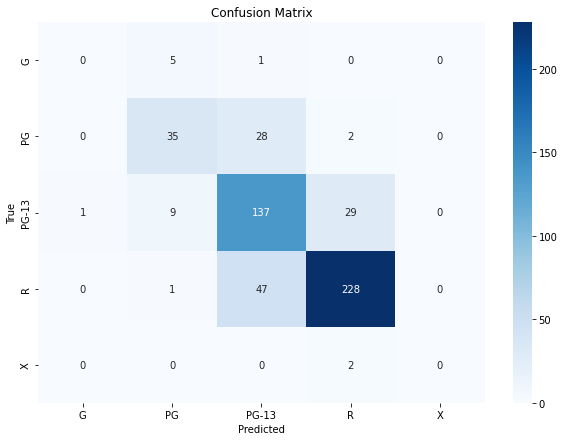


Classification Report:
              precision    recall  f1-score   support

           G       0.00      0.00      0.00         6
          PG       0.70      0.54      0.61        65
       PG-13       0.64      0.78      0.70       176
           R       0.87      0.83      0.85       276
           X       0.00      0.00      0.00         2

    accuracy                           0.76       525
   macro avg       0.44      0.43      0.43       525
weighted avg       0.76      0.76      0.76       525



c:\Users\Wyatt Williams\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Wyatt Williams\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Wyatt Williams\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [27]:
cm = confusion_matrix(y_test, y_pred)
# Assuming cm, y_test, and y_pred are already defined

labels = sorted(list(set(y_test)))

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [28]:
movies_cluster2 = movies[['Name','Date','Nudity','Violence','Profanity','Alcohol','Frightening','Country','Certificate', 'Summary_cleaned']]
movies_cluster2 = movies_cluster2[~movies_cluster2[['Nudity', 'Frightening', 'Violence', 'Profanity', 'Alcohol']].eq('No Rate').all(axis=1)]
movies_cluster2

ordinal_mapping = {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}
movies_cluster2.replace(ordinal_mapping, inplace=True)

# Assuming movies_cluster2 is your DataFrame
movies_cluster2 = movies_cluster2.fillna(0)

# Combine numerical features
X = movies_cluster2[['Nudity', 'Frightening', 'Violence', 'Profanity', 'Alcohol']]

# Convert all column names to strings
X.columns = X.columns.astype(str)

y_pred = best_rf_model.predict(X)

movies_cluster2['Pred_Certificate'] = y_pred

def predict_certificate(nudity, frightening, violence, profanity, alcohol, model):
    # Create a DataFrame with the input values
    input_data = pd.DataFrame([[nudity, frightening, violence, profanity, alcohol]],
                              columns=['Nudity', 'Frightening', 'Violence', 'Profanity', 'Alcohol'])

    # Make predictions using the trained model
    predicted_certificate = model.predict(input_data)

    # Return the predicted certificate
    return predicted_certificate

In [29]:
reverse_ordinal_mapping = {0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe'}
columns_to_replace = ['Nudity', 'Frightening', 'Violence', 'Profanity', 'Alcohol']

# Use the correct column names without the extra list
movies_cluster2[columns_to_replace] = movies_cluster2[columns_to_replace].replace(reverse_ordinal_mapping)

# Print the DataFrame with replaced values
movies_cluster2


,Name,Date,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificate,Summary_cleaned,Pred_Certificate
0,nosferatu,1922,None,Mild,None,Mild,Moderate,Germany,Not Rated,story narrate diary johann cavallius historian...,PG
1,metropolis,1927,Mild,Mild,None,Mild,Moderate,Germany,Not Rated,synopsis full minute versionprologuethe film s...,PG
2,snow white and the seven dwarfs,1937,None,Mild,None,None,Mild,United States,G,beautiful orphan princess snow white live step...,PG
4,the wizard of oz,1939,None,Mild,None,None,Mild,United States,G,dorothy gale judy garland orphan teenager life...,PG
5,citizen kane,1941,None,Mild,None,Mild,None,United States,PG,newspaper tycoon charles foster kane orson wel...,PG
...,...,...,...,...,...,...,...,...,...,...,...
2890,wrong turn,2021,Mild,Severe,Severe,Mild,Severe,Germany,R,chris finn desmond harrington way job intervie...,R
2891,yakuza princess,2021,Severe,Severe,Moderate,Mild,Mild,Brazil,R,heiress half yakuza crime syndicate forge unea...,R
2892,yes day,2021,None,Mild,None,None,None,United States,PG,allison jennifer garner carlos torres dgar ram...,PG
2893,zack snyders justice league,2021,None,Moderate,Mild,Mild,Moderate,United States,R,film open superman henry cavill doomsday kill ...,PG-13


In [30]:
movies_cluster2.query("Name == 'letters to juliet'")

,Name,Date,Nudity,Violence,Profanity,Alcohol,Frightening,Country,Certificate,Summary_cleaned,Pred_Certificate
1446,letters to juliet,2010,None,None,Mild,Mild,None,United States,PG,movie begin sophie amanda seyfried walk downto...,PG-13


##### Try out the Document Cluster 2 Model

Order of Maturity in Function
* ['Nudity', 'Frightening', 'Violence', 'Profanity', 'Alcohol']

Provide a Number for each Maturity Level
* 0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe'

In [31]:
predict_certificate(0,0,0,0,0, best_rf_model)

array(['G'], dtype=object)

##### Export the New Dataframe

* Saved Everything that I made in a concise dataframe to be used in an interface in another file

In [32]:
# Assuming 'Name' and 'Date' are the common columns
complete_movies = pd.merge(movies, movies_cluster2, on=['Name','Date','Nudity','Violence','Profanity','Alcohol','Frightening','Country','Certificate', 'Summary_cleaned'], how='left')
complete_movies = complete_movies[['Name','Country','Date','Rate','Certificate','Pred_Certificate', 'Genre', 'Nudity','Violence','Profanity','Alcohol','Frightening', 'Summarized_Text']]

# Assuming 'complete_movies' is your DataFrame
complete_movies.to_csv('complete_movies.csv', index=False)
